In [11]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import f_regression


In [12]:
dataset = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


columns = []
counts = []
categorical_columns = []

# find how much NaN a columns contains
for column in dataset:
    size = len(dataset)
    count = dataset[column].isna().sum()
    columns.append(column)
    percentage = count/size * 100
    counts.append(percentage)
    if percentage > 45:
        dataset = dataset.drop(column, axis=1)    
        print(f"{column} - {percentage:.2f}%")

trainX, trainY = dataset.loc[:, dataset.columns != 'SalePrice'], dataset.iloc[:,-1:]


# column that is present in test dataset but not in trainX dataset
test = test.filter(items=trainX.columns)



# column that is present in trainX dataset but not in test dataset
trainX = trainX.filter(items=test.columns)


Alley - 93.77%
MasVnrType - 59.73%
FireplaceQu - 47.26%
PoolQC - 99.52%
Fence - 80.75%
MiscFeature - 96.30%


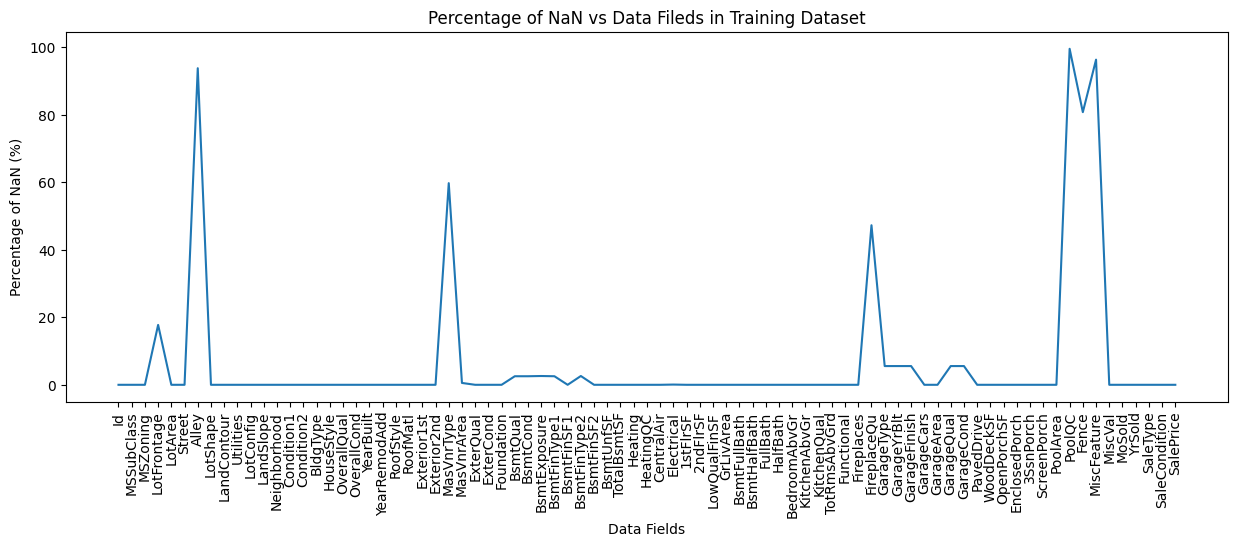

In [13]:
plt.figure().set_figwidth(15)
plt.plot(columns, counts)

plt.xlabel('Data Fields')
plt.ylabel('Percentage of NaN (%)')

plt.xticks(np.arange(len(columns)), columns, rotation=90)
plt.title("Percentage of NaN vs Data Fileds in Training Dataset")
plt.show()

In [14]:

# get categorical columns (columns whose values are not float/int)
for column in trainX:
    if not (isinstance(trainX[column][0], np.integer) or isinstance(trainX[column][0], np.floating)):
        categorical_columns.append(column)




In [15]:
# imputation; deal with NaN values
# fill NaNs for categorical as most common word
# use mean to replace NaN

for col in trainX:
    if trainX[col].isnull().any():
        if col in categorical_columns:
            trainX[col].fillna(trainX[col].mode(), inplace=True)
        else:
            trainX[col].fillna(trainX[col].mean(), inplace=True)
        
    elif test[col].isnull().any():
        if col in categorical_columns:
            test[col].fillna(test[col].mode(), inplace=True)
        else:
            test[col].fillna(test[col].mean(), inplace=True)


In [16]:

# encoding value for categorical columms


for col in categorical_columns:

    enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    enc_df_train = pd.DataFrame(enc.fit_transform(trainX[[col]]))
    enc_df_test = pd.DataFrame(enc.transform(test[[col]]))

    enc_df_train.columns = enc.get_feature_names_out([col])
    enc_df_test.columns = enc.get_feature_names_out([col])

    trainX = trainX.drop([col], axis=1)
    test = test.drop([col], axis=1)

    trainX = pd.concat([trainX, enc_df_train], axis=1)
    test = pd.concat([test, enc_df_test], axis=1)




In [17]:
x_train, x_test, y_train, y_test = train_test_split(trainX, trainY, test_size = 0.3)

In [33]:
linearReg = LinearRegression()
linearReg.fit(x_train, y_train)
print(linearReg.score(x_train, y_train))
print(linearReg.score(x_test, y_test))

0.9439795683453474
0.6229120620090278


In [47]:
# find F-statistic and p-values
f_values, p_values = f_regression(x_train, y_train.values.ravel())
k = 5
top_k_indices = np.argsort(f_values)[-k:] # sort F-value in ascending order and obtain top k indices
top_k_features = x_train.iloc[:, top_k_indices] # select top k features


In [45]:
linearReg = LinearRegression()
linearReg.fit(top_k_features, y_train.values.ravel())
predictions = linearReg.predict(x_test.iloc[:, top_k_indices])

0.7813173360675021
0.6975490900151695


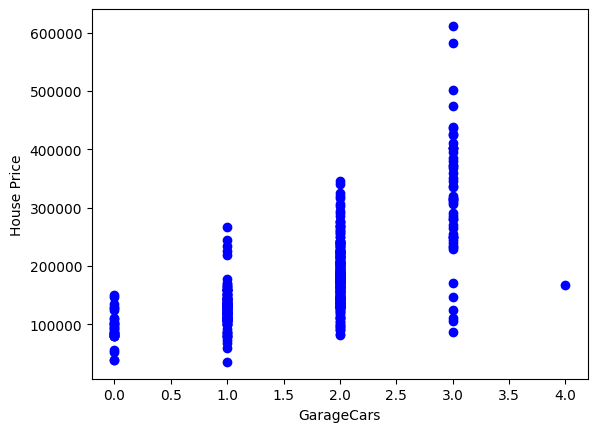

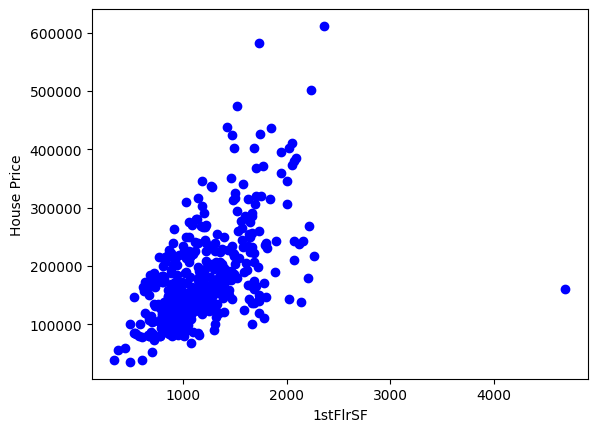

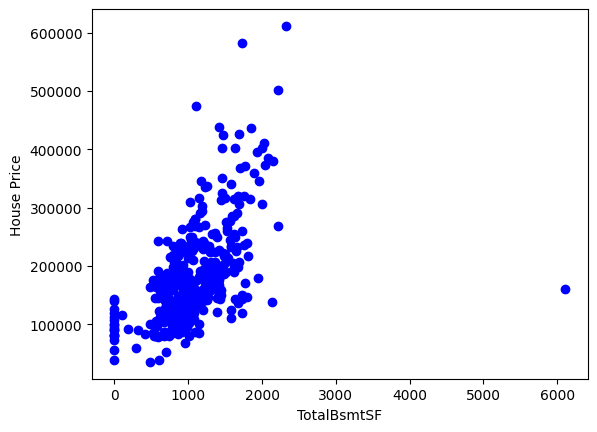

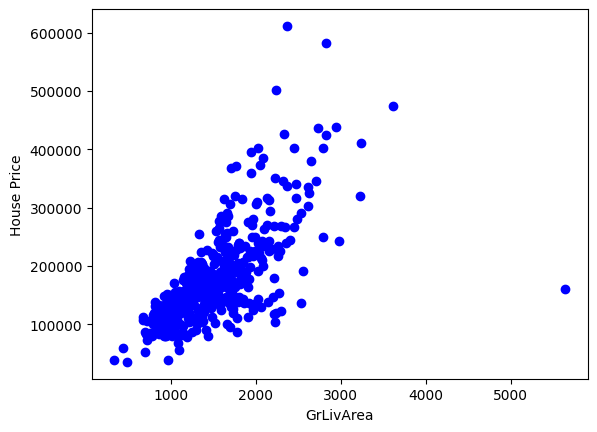

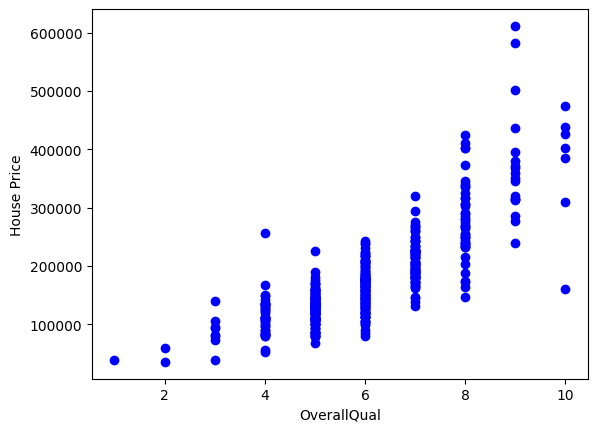

In [48]:
print(linearReg.score(top_k_features,y_train))
print(linearReg.score(x_test.iloc[:, top_k_indices], y_test))


for col in x_test.iloc[:, top_k_indices]:
    plt.xlabel(f'{col}')
    plt.ylabel('House Price')
    plt.scatter(x_test[col], y_test, color ='b')
    plt.show()


In [56]:
pred = linearReg.predict(test.iloc[:, top_k_indices])
data = {'Id': test['Id'], 'SalePrice': pred}
df = pd.DataFrame(data)  
df.to_csv('linear_regression_SalePrice_Prediction.csv')
